# Clustering and Dimension Reduction

### Data Set Information:  

The data is related to the direct telemarketing campaigns of a Portuguese bank. Telephone calls, often multiple calls were made to determine if the outcome (bank term deposit) would be subscribed (yes or no).

Dataset found on UCI site:
https://archive.ics.uci.edu/ml/datasets/Bank%2BMarketing

This analysis used the bank-additional-full.csv with 41188 results with 20 attributes ordered by date, May 2008 to November 2010. 


## Citation
Similar data originally analyzed by team:  
[Moro et al., 2014] S. Moro, P. Cortez and P. Rita. A Data-Driven Approach to Predict the Success of Bank Telemarketing. Decision Support Systems, Elsevier, 62:22-31, June 2014

In [139]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
#sns.set(style="whitegrid") # RESEARCH 'style' SETTINGS

from sklearn.preprocessing import StandardScaler, PowerTransformer # Yeo-Johnson or Boxcox
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split
from sklearn import metrics
# TIME BENCHMARKING
import time

from sklearn.cluster import KMeans

## 1. Load The Dataset

In [140]:
# LOAD FILE FROM CSV
# DROP NULLS
df = pd.read_csv(("C:/Users/DJ/Documents/AnacondaPython/Thinkful/FilesToLoad/bank-additional/bank-additional/bank_additional_full.csv")).dropna()

## 2. Exploratory Data Analysis (EDA) and Pre-Processing

In [141]:
# REMOVE LEADING AND TRAILING SPACES, CONVERT TO LOWERCASE, 
# REPLACE SPACE WITH HYPHEN, REPLACE SLASH WITH UNDERSCORE
df.columns = df.columns.str.strip().str.lower().str.replace(' ', '_').str.replace('.','_').str.replace('-','_').str.replace('/','_').str.replace('__','_')

In [142]:
# (ROWS, COLUMNS)
df.shape

(41188, 21)

In [143]:
# DUPLICATE COUNTS (ROWS, COLUMNS)
df[df.duplicated()].shape

# VIEW DUPLICATES
#df[df.duplicated(keep=False)==True].head()

(12, 21)

In [144]:
# DROP DUPLICATES
df.drop_duplicates(keep=False, inplace=True)
df[df.duplicated()].shape

(0, 21)

#### Drop columns that are not useful. Inspect if high correlations are present.
If dimension reduction like PCA, useful to look at correlation. Thus know that PCA can add value and is useful. If uncorrelated don't need PCA. 

In [145]:
corr=df[['emp_var_rate', 'cons_price_idx', 'cons_conf_idx', 'euribor3m', 'nr_employed']].corr()
corr.style.background_gradient(cmap = 'coolwarm')

#### Analysis
'emp_var_rate', 'cons_price_idx', 'euribor3m', 'nr_employed' have high collinearity, high correlations.  
'emp_var_rate' appears to have the highest cross correlation with other variables.   
cons_conf_idx has low correlation with other variables  

Keep: cons_price_idx, cons_conf_idx, nr_employed  
Drop: emp_var_rate, euribor3m  

In [146]:
# DROP DURATION, NOT PREDICTIVE, USED FOR BENCHMARKING EX POST FACTO
df.drop(['duration'], axis=1, inplace=True)
# ANALYSIS DONE ON CONTINUOUS VARIABLES, THESE HAVE HIGH COLLINEARITY
df.drop(['emp_var_rate', 'euribor3m'], axis = 1, inplace=True)
# VARIABLES SPEAK TO PRIOR CAMPAIGNS AND NOT APPLICIABLE TO NEW CAMPAIGNS IN NEW REGIONS
df.drop("contact",  axis=1, inplace=True) 
df.drop("pdays",    axis=1, inplace=True) 
df.drop("previous", axis=1, inplace=True) 
df.drop("poutcome", axis=1, inplace=True) 
# NOT RELIABLE PREDICTOR
df.drop("default", axis=1, inplace=True)

In [147]:
# COUNT NULL
null_cols = [col for col in df.columns if df[col].isnull().mean() > 0]
print(df[null_cols].isnull().mean().sort_values(ascending=False))
#df[df.isnull().any(axis=1)]

Series([], dtype: float64)


In [148]:
df['y'].value_counts()

no     36526
yes     4638
Name: y, dtype: int64

In [149]:
# COUNT EMPTY STRING
col_w_empty_str = [col for col in df.columns 
                  if (len(df[col]) == 0)]
print(col_w_empty_str)

[]


#### Transform Data: 
* Standardization/transformation is best for distance based models and PCA. 
* Yeo-Johnson transformation on continuous variables due to negative numbers and zero values
* Will standardize the other variables lower with standardscalar.

In [150]:
# ??? DOES THIS PUT BACK INTO BAG AND DUPLICATE, OR LEAVE OUT?
df = df.sample(n=10000, random_state=42) #frac=0.25

In [151]:
# TARGET STILL IN BALANCE WITH WHOLE DATASET
df['y'].value_counts()

no     8837
yes    1163
Name: y, dtype: int64

#### Pre  split yes/no %: 12%
#### Post split yes/no %: 13%

In [152]:
# TRANSFORMATION: Yeo-Johnson 
pt = PowerTransformer(standardize=True, copy=False) # Yeo-Johnson is default
df_trans = pt.fit_transform(df[['cons_price_idx', 'cons_conf_idx', 'nr_employed',
                                'age','campaign']])

C:\Users\DJ\Anaconda3\lib\site-packages\sklearn\preprocessing\data.py:2828: RuntimeWarning: overflow encountered in power
  out[pos] = (np.power(x[pos] + 1, lmbda) - 1) / lmbda
C:\Users\DJ\Anaconda3\lib\site-packages\numpy\core\_methods.py:121: RuntimeWarning: overflow encountered in multiply
  x = um.multiply(x, x, out=x)
C:\Users\DJ\Anaconda3\lib\site-packages\numpy\core\_methods.py:122: RuntimeWarning: overflow encountered in reduce
  ret = umr_sum(x, axis, dtype, out, keepdims)


In [153]:
df_trans = pd.DataFrame(df_trans, columns=['cons_price_idx_yj', 'cons_conf_idx_yj', 
                                           'nr_employed_yj', 'age_yj','campaign_yj'])

In [154]:
# PREVENT NULL VALUES FROM ENTERING DATAFRAME WHEN CONCATENATING. 
df_trans.reset_index(drop=True, inplace=True);
df.reset_index(drop=True, inplace=True);

In [155]:
df = pd.concat([df, df_trans], ignore_index=False,  axis=1)

In [156]:
# DROPPING ORIGINAL PRE-TRANSFORMATION VARIABLES
df.drop("cons_price_idx", axis=1, inplace=True) 
df.drop("cons_conf_idx",  axis=1, inplace=True) 
df.drop("nr_employed",    axis=1, inplace=True)
df.drop("age",            axis=1, inplace=True)
df.drop("campaign",       axis=1, inplace=True) 

In [157]:
df.shape

(10000, 13)

In [158]:
df.isnull().mean()

job                  0.0
marital              0.0
education            0.0
housing              0.0
loan                 0.0
month                0.0
day_of_week          0.0
y                    0.0
cons_price_idx_yj    0.0
cons_conf_idx_yj     0.0
nr_employed_yj       0.0
age_yj               0.0
campaign_yj          0.0
dtype: float64

In [159]:
# CREATE LIST
# CONTINUOUS VARIABLE LIST: USE AFTER YEO-JOHNSON TRANSFORMATION (NEGATIVE VALUES)
con_list_yj  = ['cons_price_idx_yj', 'cons_conf_idx_yj','nr_employed_yj', 'age_yj','campaign_yj']

# CATEGORICAL VARIABLE LIST
cat_list = ['job','marital','education','housing','loan','month','day_of_week','y']

In [160]:
# CHANGE NO AND YES TO 0 AND 1 
df['y'].replace(['no','yes'],[0,1],inplace=True)

### One Hot Encoding
Convert categorical variables to binary 0 or 1 for each category. Drop first category.

In [161]:
one_hot_list_all = []

In [162]:
for feature in cat_list:
    df = pd.concat([df, pd.get_dummies(df[feature], prefix=feature, drop_first=True)], axis=1)
    one_hot_list_all.extend(list(pd.get_dummies(df[feature], prefix=feature, 
                                                drop_first=True).columns))
    df.drop(feature, axis=1, inplace=True) 

In [163]:
print(one_hot_list_all)

['job_blue-collar', 'job_entrepreneur', 'job_housemaid', 'job_management', 'job_retired', 'job_self-employed', 'job_services', 'job_student', 'job_technician', 'job_unemployed', 'job_unknown', 'marital_married', 'marital_single', 'marital_unknown', 'education_basic.6y', 'education_basic.9y', 'education_high.school', 'education_illiterate', 'education_professional.course', 'education_university.degree', 'education_unknown', 'housing_unknown', 'housing_yes', 'loan_unknown', 'loan_yes', 'month_aug', 'month_dec', 'month_jul', 'month_jun', 'month_mar', 'month_may', 'month_nov', 'month_oct', 'month_sep', 'day_of_week_mon', 'day_of_week_thu', 'day_of_week_tue', 'day_of_week_wed', 'y_1']


In [164]:
list_all = df.columns.tolist()

In [165]:
df.head()

cons_price_idx_yj  cons_conf_idx_yj  nr_employed_yj    age_yj  campaign_yj  \
0           0.565043         -0.448605        0.997875  0.031062     1.407010   
1          -0.279301          0.958716        0.997875  0.322314    -1.048285   
2          -0.279301          0.958716        0.997875  0.837284    -1.048285   
3          -1.165295         -1.282527       -1.143810 -0.287896    -1.048285   
4          -0.683747         -0.289088        0.245483 -1.172259     0.842121   

   job_blue-collar  job_entrepreneur  job_housemaid  job_management  \
0                1                 0              0               0   
1                0                 0              0               0   
2                0                 0              0               1   
3                0                 0              0               0   
4                0                 0              0               0   

   job_retired  ...  month_mar  month_may  month_nov  month_oct  month_sep  \
0            0  ...          0          0          0          0          0   
1            0  ...          0          0          0          0          0   
2            0  ...          0          0          0          0          0   
3            0  ...          0          1          0          0          0   
4            0  ...          0          0          1          0          0   

   day_of_week_mon  day_of_week_thu  day_of_week_tue  day_of_week_wed  y_1  
0                0                0                1                0    0  
1                1                0                0                0    0  
2                0                0                1                0    0  
3                0                1                0                0    0  
4                0                0                0                1    0  

[5 rows x 44 columns]

In [166]:
df['y_1'].value_counts()

0    8837
1    1163
Name: y_1, dtype: int64

In [167]:
# ORIG IN THINKFUL EXAMPLE
X_one_hot = StandardScaler().fit_transform(df[one_hot_list_all])
X_one_hot = pd.DataFrame(X_one_hot)

# CREATE STANDARDIZED X FOR ALL VARIABLES INCLUDING y THE TARGET VARIABLE NORMALLY
X_std = pd.concat([df[con_list_yj], X_one_hot], axis=1)

# STORE FEATURES AND PREDICT CLUSTER MEMBERSHIPS
ypred = pd.DataFrame()

# TARGET VARIABLE FOR LABELING AND PREDICTION COMPARISON
y = df['y_1']

In [168]:
print(len(list_all))

44


In [169]:
np.random.seed(0)
my_matrix = np.random.randn(20, 5)

my_model = PCA(n_components=5)
my_model.fit_transform(my_matrix)

print (my_model.explained_variance_)
print (my_model.explained_variance_ratio_)
print (my_model.explained_variance_ratio_.cumsum())

[1.58691121 1.36183634 1.02149516 0.64960702 0.33188507]
[0.32047581 0.27502207 0.20629036 0.13118776 0.067024  ]
[0.32047581 0.59549787 0.80178824 0.932976   1.        ]


In [170]:
# IMBALANCED DATA SET, DON'T SMOTE AS DON'T DON'T KNOW TARGET VAR IN UNSTRUCTURED
# CAN USE y, TARGET VARIABLE IN FEATURE SET AS A RESULT
# Computing the first principal components

# PCA BOTH REDUCES DIMENSIONS AND HELPS VISUALIZE X, y, 2 DIMENSIONAL
#X_pca = PCA(n_components=2).fit_transform(X_std)
pca = PCA(n_components=2)
pca.fit_transform(X_std)

print (pca.explained_variance_)
print (pca.explained_variance_ratio_)
print (pca.explained_variance_ratio_.cumsum())

[2.57117765 2.24801451]
[0.05843001 0.05108613]
[0.05843001 0.10951614]


In [171]:
X_pca = pca.fit_transform(X_std)

In [172]:
# SPLIT THE DATA INTO FOUR EQUAL SAMPLES THEN PLOT, NOT USING TARGET SO STANDARDIZED X WITH PCA X:
X_half1, X_half2, X_pcahalf1, X_pcahalf2 = train_test_split(
    X_std,
    X_pca,
    test_size=0.5,
    random_state=42)

In [173]:
xpca_vis = X_pcahalf2.copy()

In [174]:
xpca_vis=pd.DataFrame(xpca_vis)

In [175]:
xpca_vis.head()

0         1
0  3.225561  1.268220
1 -2.224525 -1.354178
2 -0.307919 -0.276318
3  2.656162 -1.184076
4 -2.114609  1.113753

In [176]:
xpca_vis.describe()

0            1
count  5000.000000  5000.000000
mean      0.000277     0.004884
std       1.609335     1.521454
min      -3.936680    -4.252681
25%      -1.152646    -1.014949
50%      -0.162228    -0.052422
75%       1.032416     1.000429
max       6.473439     5.984983

In [34]:
X_std.shape

(10000, 44)

In [177]:
# Computing the first principal components
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_std)

# Split the data into four equally-sized samples. First we break it in half:
X_half1, X_half2, X_pcahalf1, X_pcahalf2 = train_test_split(
    X_std,
    X_pca,
    test_size=0.5,
    random_state=42)

In [180]:
# Data frame to store features and predicted cluster memberships.
ypred = pd.DataFrame()

# Pass a list of tuples and a counter that increments each time we go
# through the loop. The tuples are the data to be used by k-means,
# and the PCA-derived features for graphing. We use k-means to fit a
# model to the data, then store the predicted values and the two-feature
# PCA solution in the data frame.
for counter, data in enumerate([
    (X_half1, X_pcahalf1),
    (X_half2, X_pcahalf2)]):
    
    # Put the features into ypred.
    ypred['pca_f1' + '_sample' + str(counter)] = data[1][:, 0]
    ypred['pca_f2' + '_sample' + str(counter)] = data[1][:, 1]
    
    # Generate cluster predictions and store them for clusters 2 to 4.
    for nclust in range(2, 5):
        pred = KMeans(n_clusters=nclust, random_state=12).fit_predict(data[counter])
        ypred['clust' + str(nclust) + '_sample' + str(counter)] = pred

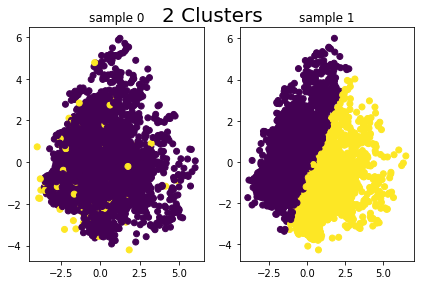

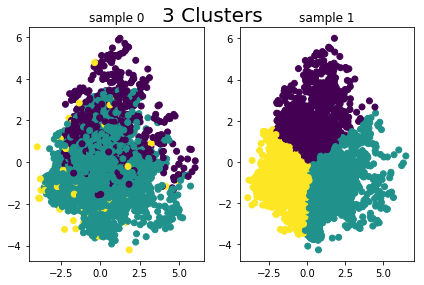

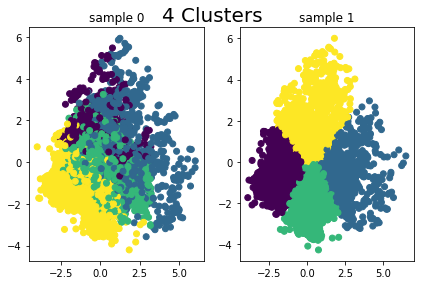

In [181]:
# ??? WHY DOES IT SO PERFECT ON sample 1 PREDICTIONS
# !!! ASK ZACH
# For each  number of clusters, plot the clusters using the
# pca features for each sample.
for cluster in range(2, 5):
    
    # Make a grid of subplots.
    f, axarr = plt.subplots(1, 2)
    
    # Make a plot for each sample.
    for i in range(2):
        
        # PCA-created features.
        x_sub = ypred['pca_f1_sample{}'.format(i)]
        y_sub = ypred['pca_f2_sample{}'.format(i)]
        
        # Cluster assignments.
        c = ypred['clust{}_sample{}'.format(cluster, i)]
        
        # Assign the subplot to its place on the grid.
        axarr[i].scatter(x_sub, y_sub, c=c)
        axarr[i].set_title('sample {}'.format(i))
    
    # Space out the plots so that the headings don't overlap axis values.
    plt.suptitle('{} Clusters'.format(cluster), fontsize=20)
    plt.tight_layout()
    plt.show()
    print('\n')

### K-MEANS

#### Analysis:

Cluster analysis for sample1 appear to have clear designations, where sample0 is not consistent at any level using KMeans. Variance is high between sample0 to sample1, unstable.

In [70]:
pred_2 = KMeans(n_clusters=10, random_state=42).fit_predict(X_std)
pred_3 = KMeans(n_clusters=20, random_state=42).fit_predict(X_std)
pred_4 = KMeans(n_clusters=30, random_state=42).fit_predict(X_std)
pred_5 = KMeans(n_clusters=40, random_state=42).fit_predict(X_std)

print("ARI for ten    cluster k-means: {}".format(
    metrics.adjusted_rand_score(y, pred_2)))
print("ARI for twenty cluster k-means: {}".format(
    metrics.adjusted_rand_score(y, pred_3)))
print("ARI for thirty cluster k-means: {}".format(
    metrics.adjusted_rand_score(y, pred_4)))
print("ARI for forty  cluster k-means: {}".format(
    metrics.adjusted_rand_score(y, pred_5)))

ARI for ten    cluster k-means: 0.002925952496064214
ARI for twenty cluster k-means: 0.007104756665916021
ARI for thirty cluster k-means: 0.0035968941757726467
ARI for forty  cluster k-means: 0.0038412350131450533


In [36]:
pred_2 = KMeans(n_clusters=10, random_state=42).fit_predict(X_std)
pred_3 = KMeans(n_clusters=20, random_state=42).fit_predict(X_std)
pred_4 = KMeans(n_clusters=30, random_state=42).fit_predict(X_std)
pred_5 = KMeans(n_clusters=40, random_state=42).fit_predict(X_std)

print("Silhouette score for ten    cluster k-means: {}".format(
    metrics.silhouette_score(X_std, pred_2, metric='euclidean')))
print("Silhouette score for twenty cluster k-means: {}".format(
    metrics.silhouette_score(X_std, pred_3, metric='euclidean')))
print("Silhouette score for thirty  cluster k-means: {}".format(
    metrics.silhouette_score(X_std, pred_4, metric='euclidean')))
print("Silhouette score for forty   cluster k-means: {}".format(
    metrics.silhouette_score(X_std, pred_5, metric='euclidean')))

Silhouette score for ten    cluster k-means: 0.09080913786661172
Silhouette score for twenty cluster k-means: 0.11376849079345856
Silhouette score for thirty  cluster k-means: 0.1376900500962964
Silhouette score for forty   cluster k-means: 0.1278283791839939


#### Analysis

ARI:         Highest ARI score is for 20 clusters, all in all ARI quite low
Silhouette:  Highest silhouette score is for 30 clusters in this analysis. More clusters appear to perform better than fewer clusters on the whole.

Note: Silhouette, doesn't compare to class, looks at data itself. Where ari, does compare to class. Silhouette if no labels or clustering purist. 

### Heirarchical Clustering

In [37]:
from scipy.cluster.hierarchy import dendrogram, linkage
from sklearn.cluster import AgglomerativeClustering

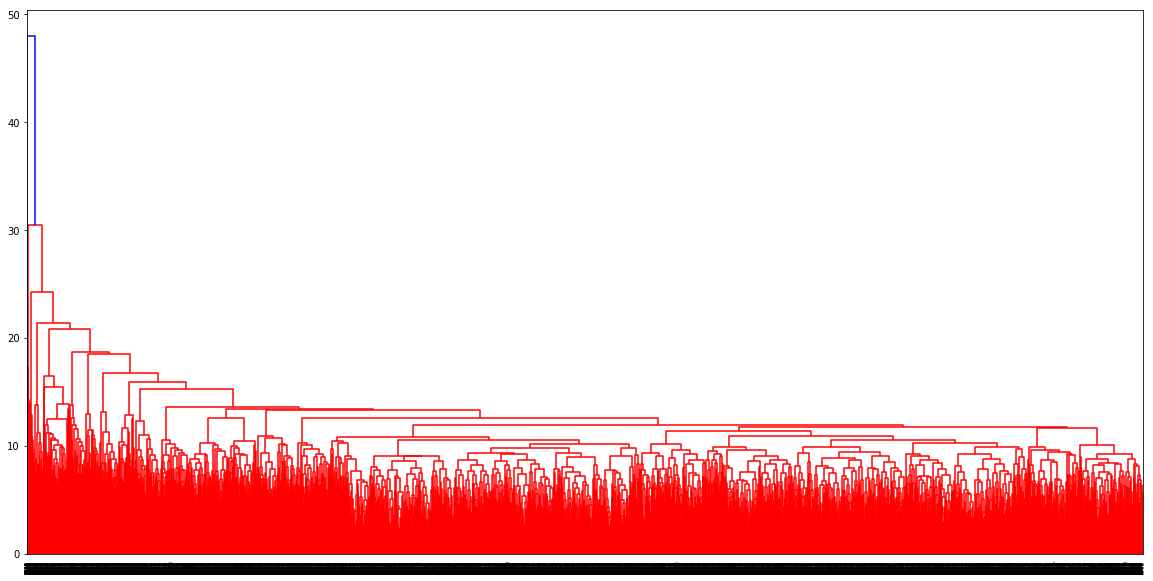

In [38]:
plt.figure(figsize=(20,10))
dendrogram(linkage(X_std, method='complete'))
plt.show()

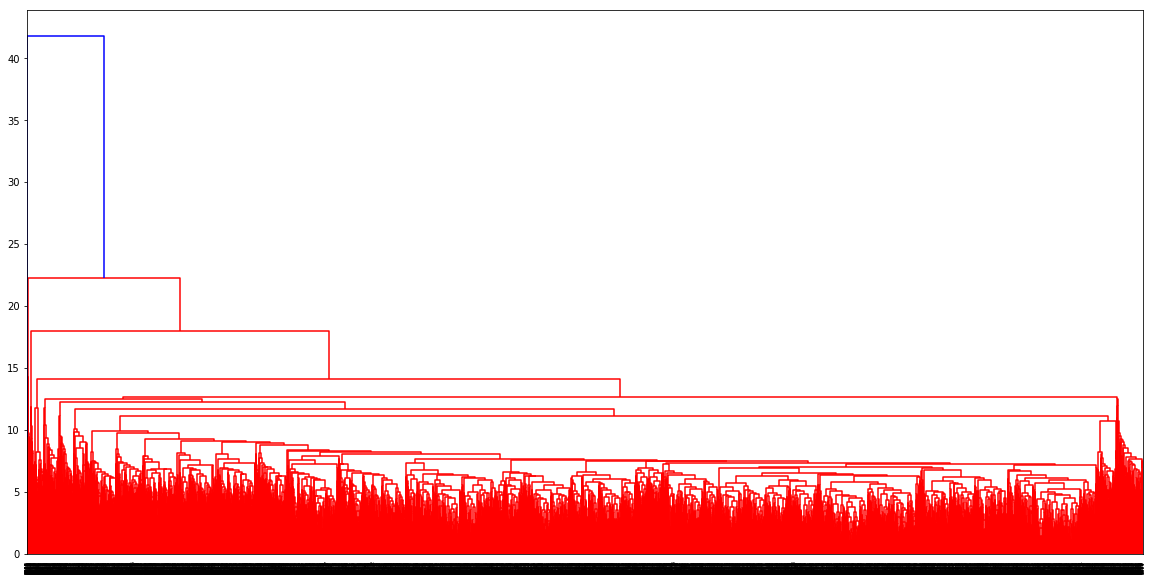

In [39]:
plt.figure(figsize=(20,10))
dendrogram(linkage(X_std, method='average'))
plt.show()

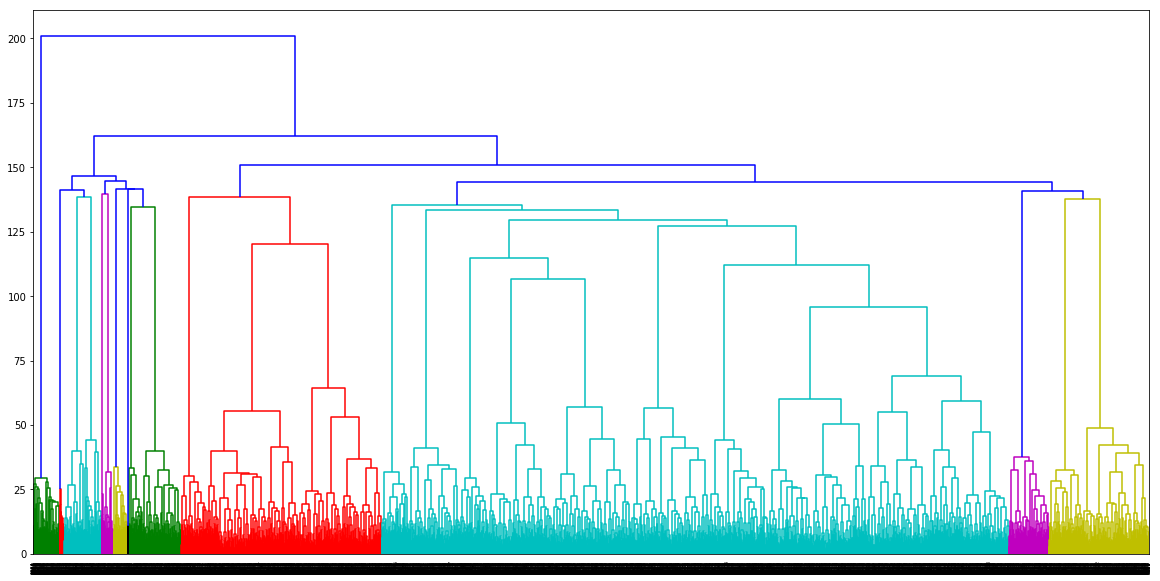

In [40]:
plt.figure(figsize=(20,10))
dendrogram(linkage(X_std, method='ward'))
plt.show()

#### Analysis:

The ward method appears to have the clearest delineations between clusters, with approximately 11. Intuitively this makes sense as the clusters in the K-means investigation appeared to be spherical. Ward only works with Euclidean distance.


In [41]:
agg_cluster = AgglomerativeClustering(linkage='ward', 
                                      affinity='euclidean',
                                      n_clusters=11)

clusters = agg_cluster.fit_predict(X_std)

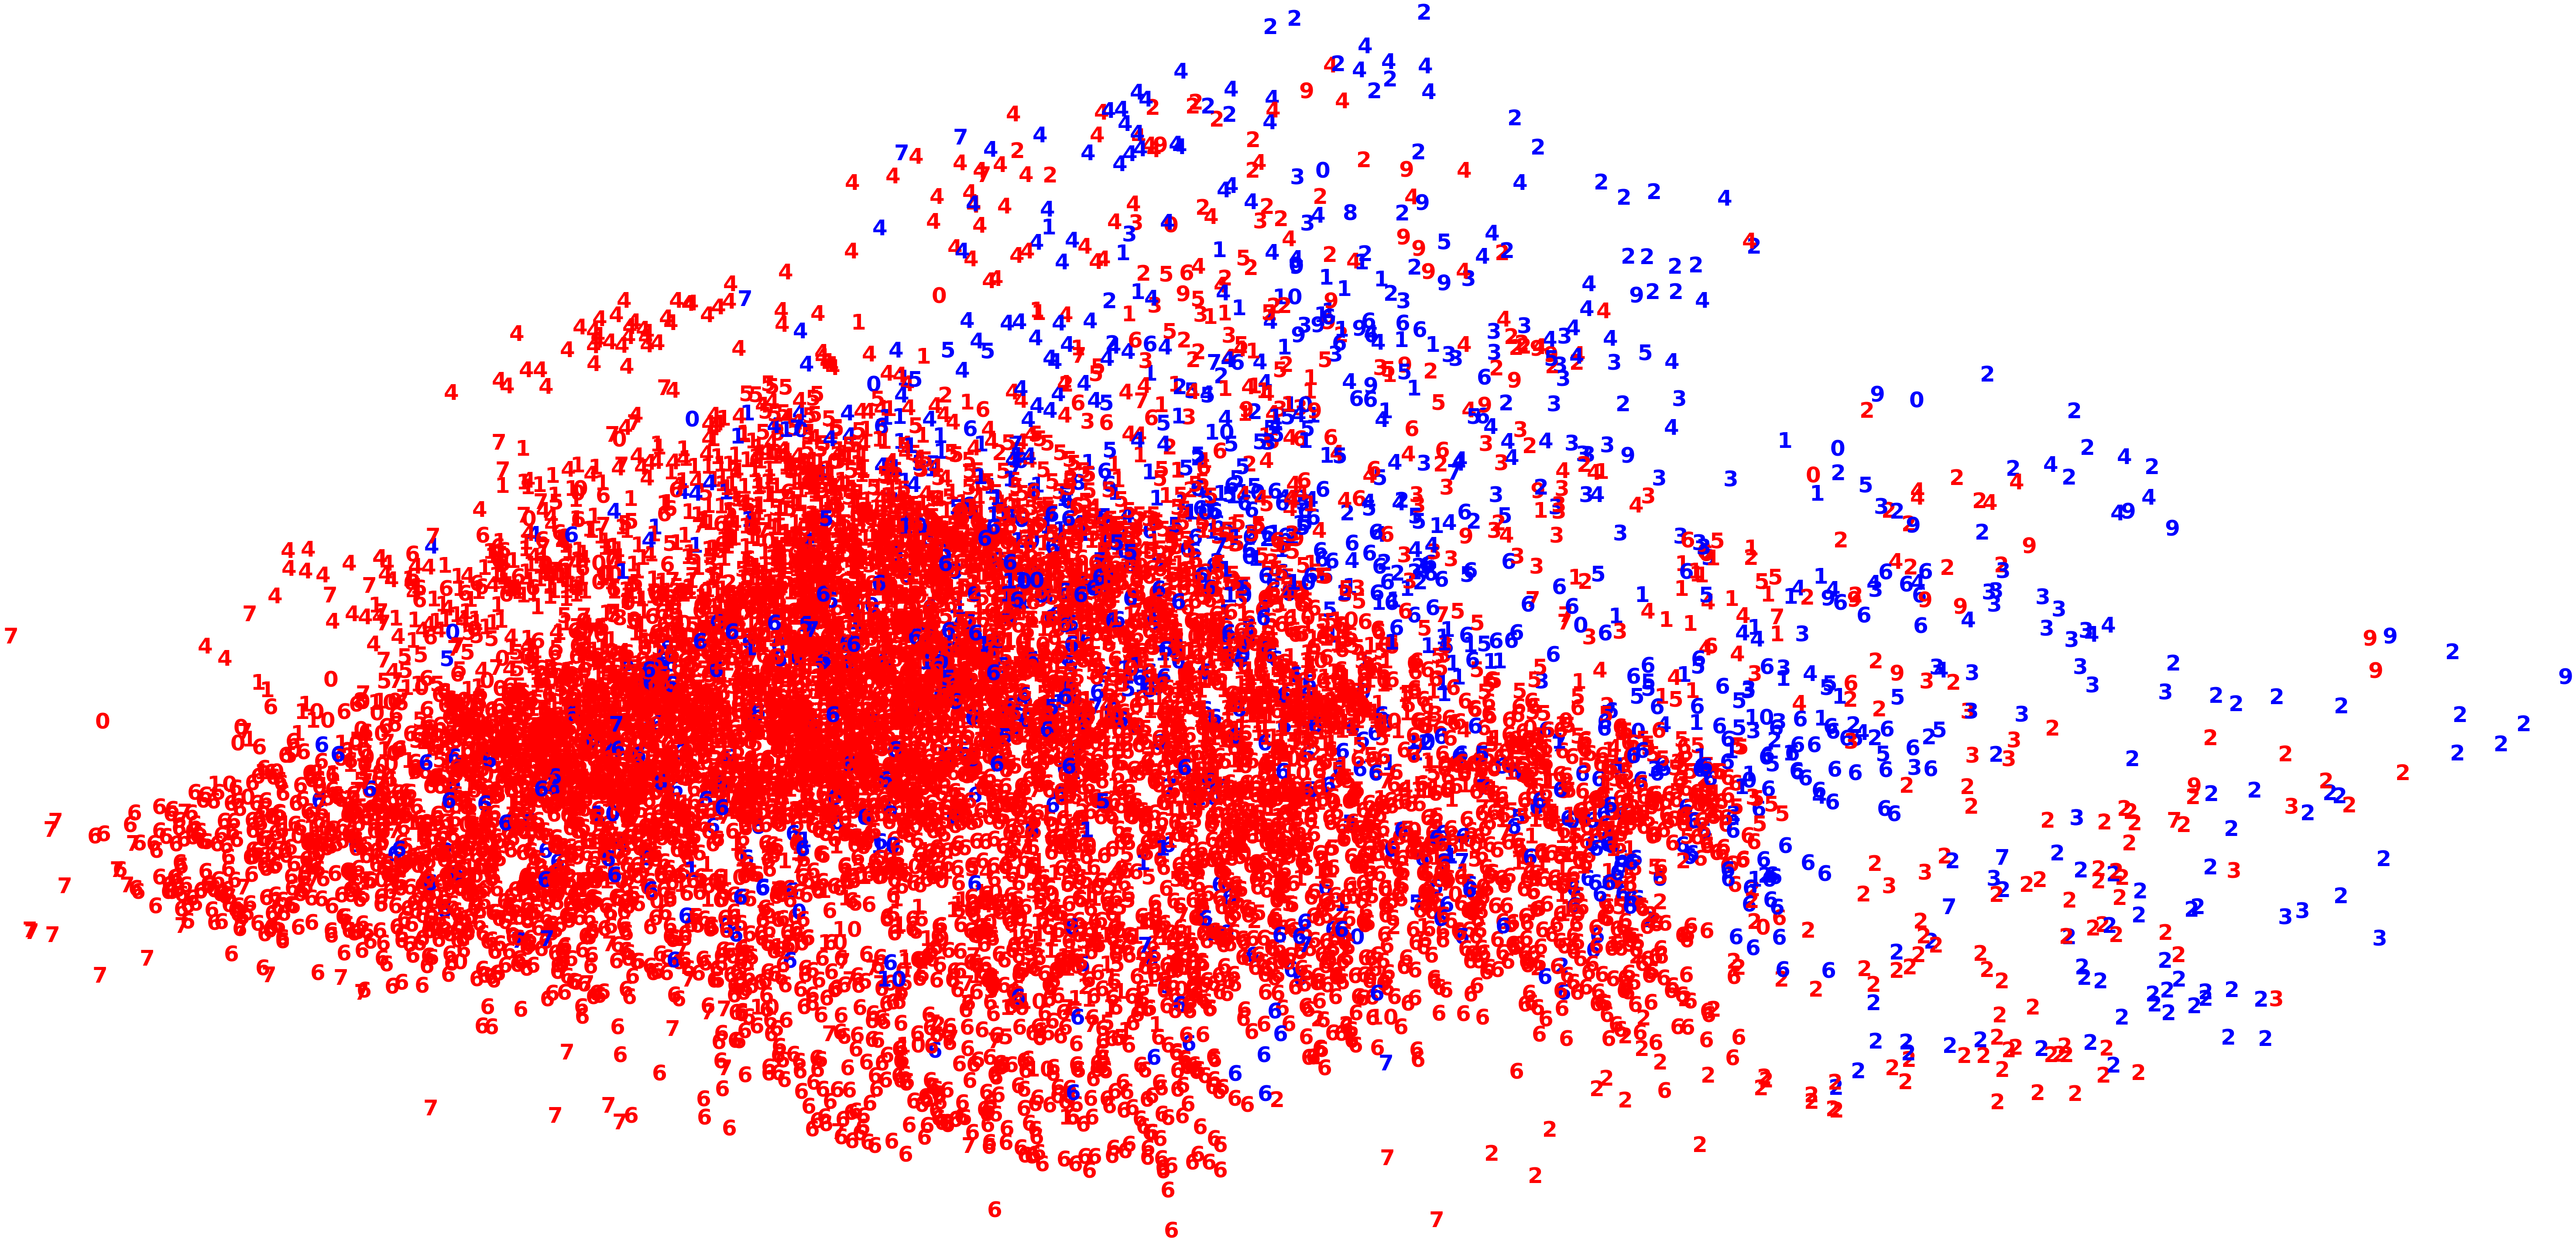

In [42]:
plt.figure(figsize=(10,5))
colours = 'rbg'
for i in range(X_pca.shape[0]):
    plt.text(X_pca[i, 0], X_pca[i, 1], str(clusters[i]),
             color=colours[y[i]],
             fontdict={'weight': 'bold', 'size': 50}
        )

plt.xticks([])
plt.yticks([])
plt.axis('off')
plt.show()

# BLUE AND RED ARE THE ACTUAL TARGET. THE NUMBERS ARE THE CLUSTER PREDICTIONS.

In [43]:
print("Adjusted Rand Index of the Agglomerative Clustering solution: {}"
      .format(metrics.adjusted_rand_score(y, clusters)))
print("The Silhoutte score of the Agglomerative Clustering solution: {}"
      .format(metrics.silhouette_score(X_std, clusters, metric='euclidean')))

Adjusted Rand Index of the Agglomerative Clustering solution: 0.05355418565748491
The Silhoutte score of the Agglomerative Clustering solution: 0.08556030882559064


#### Analysis:
ARI: Agglomerative Clustering (.05) is low, but higher than K-means (.007).  
Silhouette score: Agglomerative Clustering (.09) is low, and lower than K-means(.138).  

### DBSCAN

#### Note, possible application, get highest number, then put that into k-means ... appears to be 15

In [44]:
from sklearn.cluster import DBSCAN

# DENSITY BASED CLUSTERING ALGORITHM
dbscan_cluster = DBSCAN(eps=4, min_samples=10)

clusters = dbscan_cluster.fit_predict(X_std)

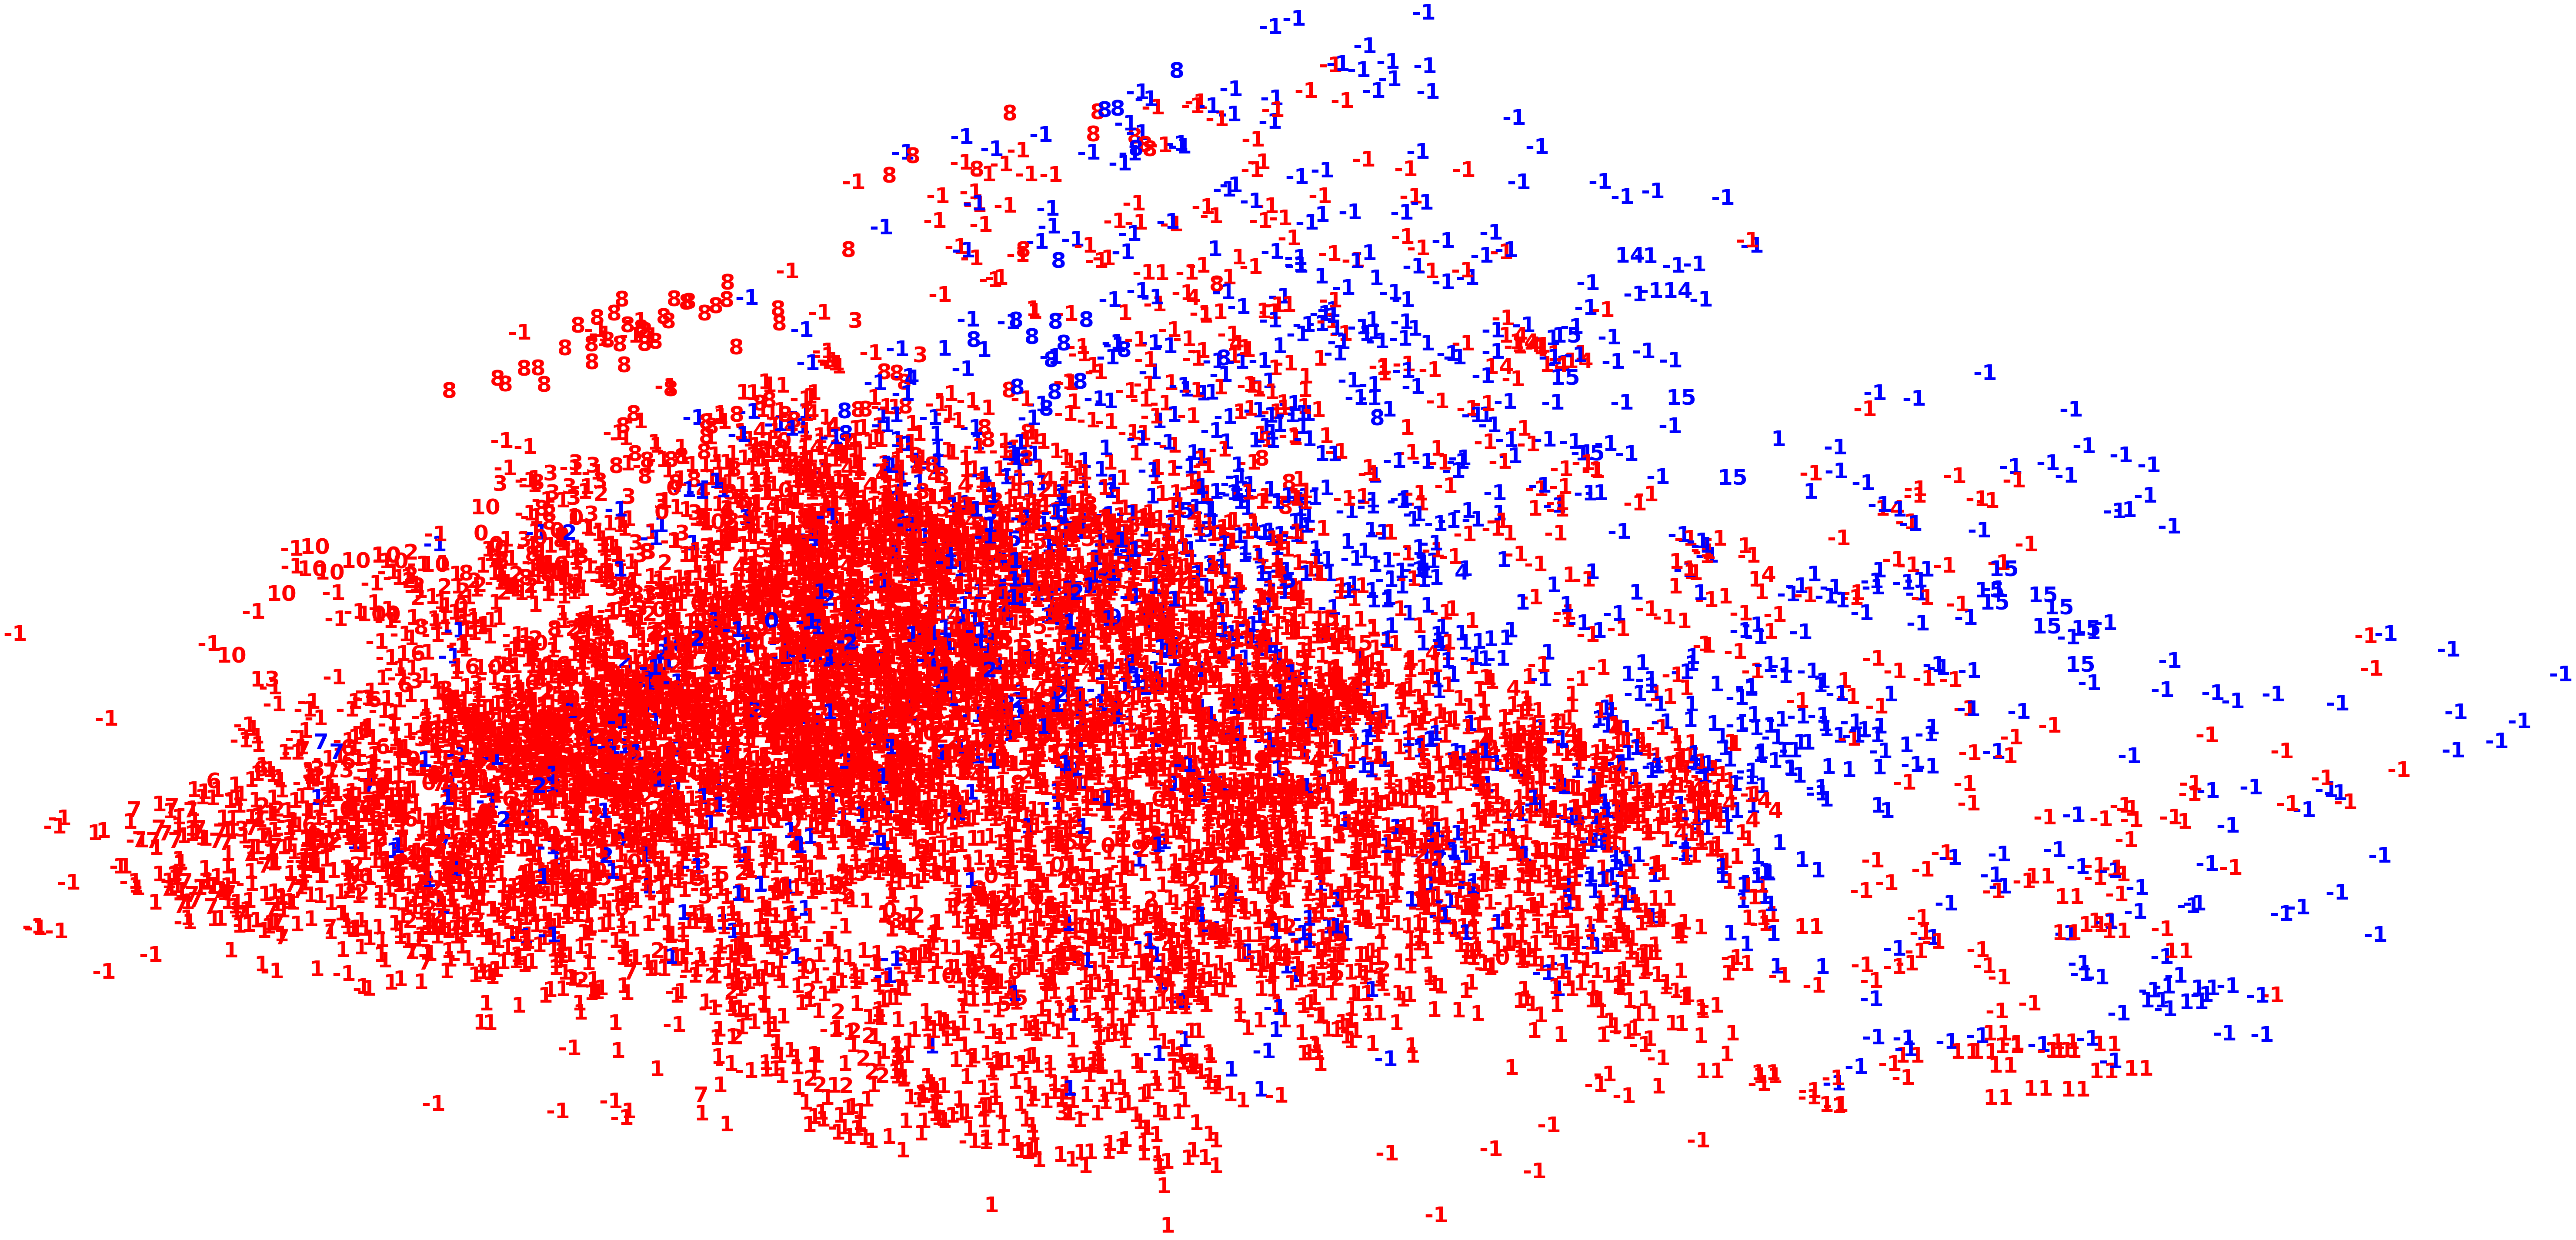

In [45]:
plt.figure(figsize=(10,5))
colours = 'rbg'
for i in range(X_pca.shape[0]):
    plt.text(X_pca[i, 0], X_pca[i, 1], str(clusters[i]),
             color=colours[y[i]],
             fontdict={'weight': 'bold', 'size': 50}
        )

plt.xticks([])
plt.yticks([])
plt.axis('off')
plt.show()

In [46]:
print("Adjusted Rand Index of the DBSCAN solution: {}"
      .format(metrics.adjusted_rand_score(y, clusters)))

Adjusted Rand Index of the DBSCAN solution: 0.09765362976308885


In [47]:
print("The silhouette score of the DBSCAN solution: {}"
      .format(metrics.silhouette_score(X_std, clusters, metric='euclidean')))

The silhouette score of the DBSCAN solution: 0.004372628824039121


#### Analysis:  
ARI:  
    Agglomerative Clustering (.05)   
    K-means                  (.007)  
    DBSCAN                   (.097)  
    
Silhouette score:  
    Agglomerative Clustering (.09)    
    K-means                  (.138)  
    DBSCAN                   (.004)    

### GMM

In [48]:
from matplotlib.patches import Ellipse
from sklearn.mixture import GaussianMixture

#gmm_cluster = GaussianMixture(n_components=2, random_state=42, covariance_type='full')
#gmm_cluster = GaussianMixture(n_components=2, random_state=42, covariance_type='tied')
#gmm_cluster = GaussianMixture(n_components=2, random_state=42, covariance_type='diag')
gmm_cluster = GaussianMixture(n_components=2, random_state=42, covariance_type='spherical')

clusters = gmm_cluster.fit_predict(X_std)

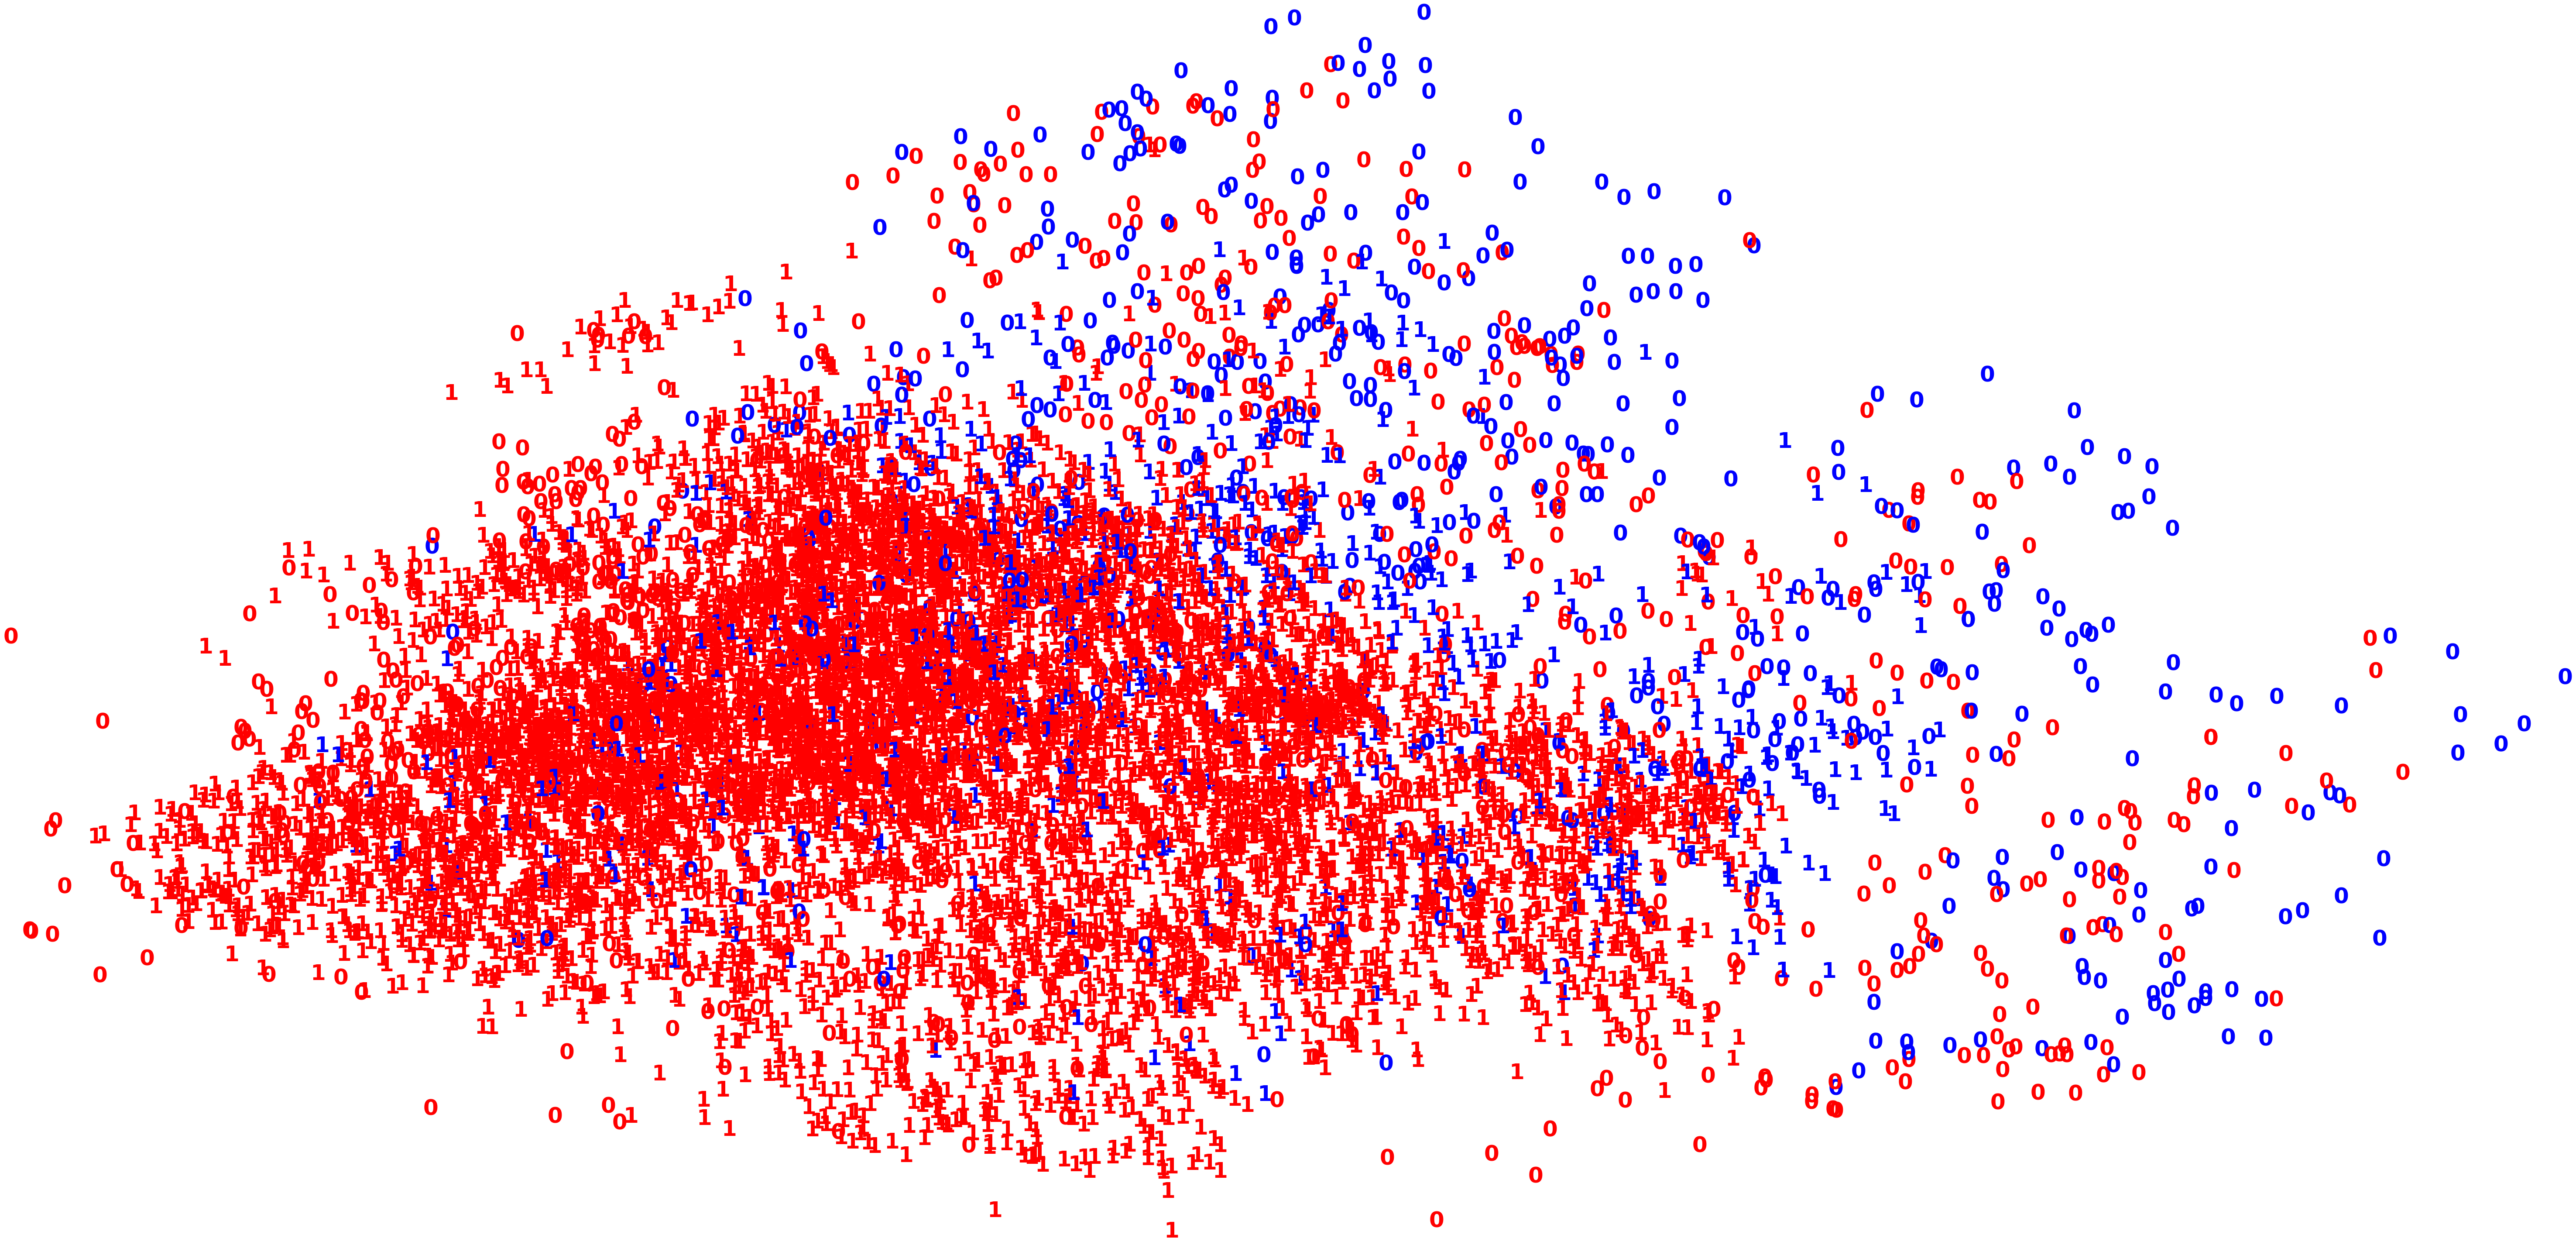

In [49]:
plt.figure(figsize=(10,5))
colours = 'rbg'
for i in range(X_pca.shape[0]):
    plt.text(X_pca[i, 0], X_pca[i, 1], str(clusters[i]),
             color=colours[y[i]],
             fontdict={'weight': 'bold', 'size': 50}
        )

plt.xticks([])
plt.yticks([])
plt.axis('off')
plt.show()

In [50]:
print("full")
gmm_cluster = GaussianMixture(n_components=2, random_state=42, covariance_type='full')
clusters = gmm_cluster.fit_predict(X_std)
print("Adjusted Rand Index of the GMM solution: {:.3f}"
      .format(metrics.adjusted_rand_score(y, clusters)))
print("The silhoutte score of the GMM solution: {:.3f}"
      .format(metrics.silhouette_score(X_std, clusters, metric='euclidean')))

print("tied")
gmm_cluster = GaussianMixture(n_components=2, random_state=42, covariance_type='tied')
clusters = gmm_cluster.fit_predict(X_std)
print("Adjusted Rand Index of the GMM solution: {:.3f}"
      .format(metrics.adjusted_rand_score(y, clusters)))
print("The silhoutte score of the GMM solution: {:.3f}"
      .format(metrics.silhouette_score(X_std, clusters, metric='euclidean')))

print("diag")
gmm_cluster = GaussianMixture(n_components=2, random_state=42, covariance_type='diag')
clusters = gmm_cluster.fit_predict(X_std)
print("Adjusted Rand Index of the GMM solution: {:.3f}"
      .format(metrics.adjusted_rand_score(y, clusters)))
print("The silhoutte score of the GMM solution: {:.3f}"
      .format(metrics.silhouette_score(X_std, clusters, metric='euclidean')))

print("spherical")
gmm_cluster = GaussianMixture(n_components=2, random_state=42, covariance_type='spherical')
clusters = gmm_cluster.fit_predict(X_std)
print("Adjusted Rand Index of the GMM solution: {:.3f}"
      .format(metrics.adjusted_rand_score(y, clusters)))
print("The silhoutte score of the GMM solution: {:.3f}"
      .format(metrics.silhouette_score(X_std, clusters, metric='euclidean')))

full
Adjusted Rand Index of the GMM solution: 0.066
The silhoutte score of the GMM solution: 0.061
tied
Adjusted Rand Index of the GMM solution: 0.012
The silhoutte score of the GMM solution: 0.049
diag
Adjusted Rand Index of the GMM solution: 0.053
The silhoutte score of the GMM solution: 0.064
spherical
Adjusted Rand Index of the GMM solution: 0.188
The silhoutte score of the GMM solution: 0.245


#### Analysis: 
Would benefit from doing a GridSearch with GMM. Go through each number of clusters, for each covariance type and print results. 

GMM with 2 components performs best so far.

ARI:  
    Agglomerative Clustering (.05)   
    K-means                  (.007)  
    DBSCAN                   (.097)  
    GMM - spherical          (.188)  
    
Silhouette score:  
    Agglomerative Clustering (.09)    
    K-means                  (.138)  
    DBSCAN                   (.004)  
    GMM - spherical          (.245)  

### PCA - Dimensionality reduction

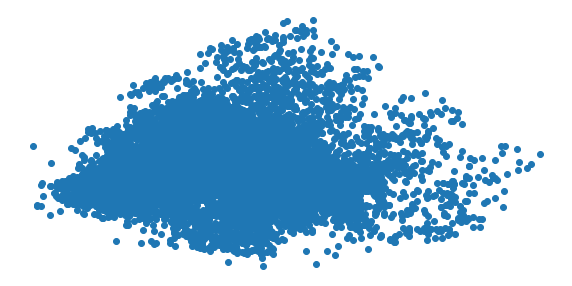

In [51]:
plt.figure(figsize=(10,5))
plt.scatter(X_pca[:, 0], X_pca[:, 1])
plt.xticks([])
plt.yticks([])
plt.axis('off')
plt.show()

In [75]:
print (X_pca.explained_variance_)
print (X_pca.explained_variance_ratio_)
print (X_pca.explained_variance_ratio_.cumsum())

AttributeError: 'numpy.ndarray' object has no attribute 'explained_variance_'

#### Analysis:
Clusters don't appear to be recognizable on a two dimension, unlabeled chart with PCA.

### t-SNE - Dimensionality reduction

In [52]:
from sklearn.manifold import TSNE

In [53]:
time_start = time.time()

# t-Distributed Stochastic Neighbor Embedding
tsne = TSNE(n_components=2, verbose=1, perplexity=5, n_iter=300)
tsne_results = tsne.fit_transform(X_std)

print('t-SNE done! Time elapsed: {} seconds'.format(time.time()-time_start))

[t-SNE] Computing 16 nearest neighbors...
[t-SNE] Indexed 10000 samples in 0.193s...
[t-SNE] Computed neighbors for 10000 samples in 6.431s...
[t-SNE] Computed conditional probabilities for sample 1000 / 10000
[t-SNE] Computed conditional probabilities for sample 2000 / 10000
[t-SNE] Computed conditional probabilities for sample 3000 / 10000
[t-SNE] Computed conditional probabilities for sample 4000 / 10000
[t-SNE] Computed conditional probabilities for sample 5000 / 10000
[t-SNE] Computed conditional probabilities for sample 6000 / 10000
[t-SNE] Computed conditional probabilities for sample 7000 / 10000
[t-SNE] Computed conditional probabilities for sample 8000 / 10000
[t-SNE] Computed conditional probabilities for sample 9000 / 10000
[t-SNE] Computed conditional probabilities for sample 10000 / 10000
[t-SNE] Mean sigma: 1.081932
[t-SNE] KL divergence after 250 iterations with early exaggeration: 86.170944
[t-SNE] KL divergence after 300 iterations: 3.768627
t-SNE done! Time elapsed: 

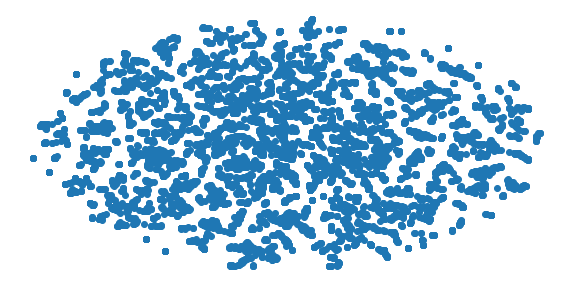

In [54]:
plt.figure(figsize=(10,5))
plt.scatter(tsne_results[:, 0], tsne_results[:, 1])
plt.xticks([])
plt.yticks([])
plt.axis('off')
plt.show()

In [55]:
time_start = time.time()

# t-Distributed Stochastic Neighbor Embedding
tsne = TSNE(n_components=2, verbose=1, perplexity=40, n_iter=300)
tsne_results = tsne.fit_transform(X_std)

print('t-SNE done! Time elapsed: {} seconds'.format(time.time()-time_start))

[t-SNE] Computing 121 nearest neighbors...
[t-SNE] Indexed 10000 samples in 0.199s...
[t-SNE] Computed neighbors for 10000 samples in 7.154s...
[t-SNE] Computed conditional probabilities for sample 1000 / 10000
[t-SNE] Computed conditional probabilities for sample 2000 / 10000
[t-SNE] Computed conditional probabilities for sample 3000 / 10000
[t-SNE] Computed conditional probabilities for sample 4000 / 10000
[t-SNE] Computed conditional probabilities for sample 5000 / 10000
[t-SNE] Computed conditional probabilities for sample 6000 / 10000
[t-SNE] Computed conditional probabilities for sample 7000 / 10000
[t-SNE] Computed conditional probabilities for sample 8000 / 10000
[t-SNE] Computed conditional probabilities for sample 9000 / 10000
[t-SNE] Computed conditional probabilities for sample 10000 / 10000
[t-SNE] Mean sigma: 2.063286
[t-SNE] KL divergence after 250 iterations with early exaggeration: 74.398651
[t-SNE] KL divergence after 300 iterations: 2.419377
t-SNE done! Time elapsed:

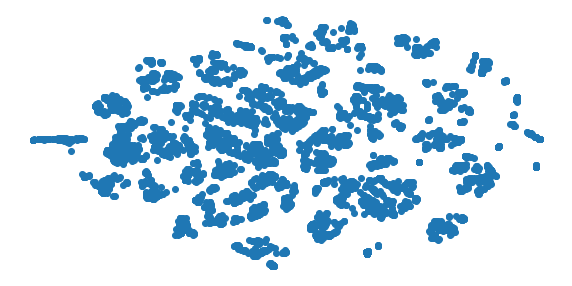

In [56]:
plt.figure(figsize=(10,5))
plt.scatter(tsne_results[:, 0], tsne_results[:, 1])
plt.xticks([])
plt.yticks([])
plt.axis('off')
plt.show()

#### Analysis:
Looks to have seperated out into distinguishiable clusters. Perplexity of 40 is better than 5.

### UMAP - Dimensionality reduction

Notes: more stable,  not stochastic, not optimizing   
Use diff # k do low and high, say 5 and 20  

elbow - can go into that, good to learn, standard with k-means   
nlp, eda, clustering, particularly topic extraction can do clustering on featurized data  

In [57]:
import umap

In [58]:
time_start = time.time()

#Uniform Manifold Approximation and Projection
umap_results = umap.UMAP(n_neighbors=5,
                      min_dist=0.3,
                      metric='correlation').fit_transform(X_std)

print('UMAP done! Time elapsed: {} seconds'.format(time.time()-time_start))

C:\Users\DJ\Anaconda3\lib\site-packages\umap\spectral.py:229: UserWarning: Embedding a total of 17 separate connected components using meta-embedding (experimental)
  n_components


UMAP done! Time elapsed: 19.90731167793274 seconds


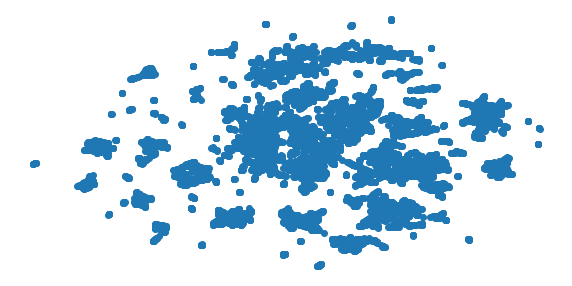

In [59]:
plt.figure(figsize=(10,5))
plt.scatter(umap_results[:, 0], umap_results[:, 1])
plt.xticks([])
plt.yticks([])
plt.axis('off')
plt.show()

In [60]:
time_start = time.time()

#Uniform Manifold Approximation and Projection
umap_results = umap.UMAP(n_neighbors=20,
                      min_dist=0.3,
                      metric='correlation').fit_transform(X_std)

print('UMAP done! Time elapsed: {} seconds'.format(time.time()-time_start))

C:\Users\DJ\Anaconda3\lib\site-packages\umap\spectral.py:229: UserWarning: Embedding a total of 4 separate connected components using meta-embedding (experimental)
  n_components


UMAP done! Time elapsed: 27.33383059501648 seconds


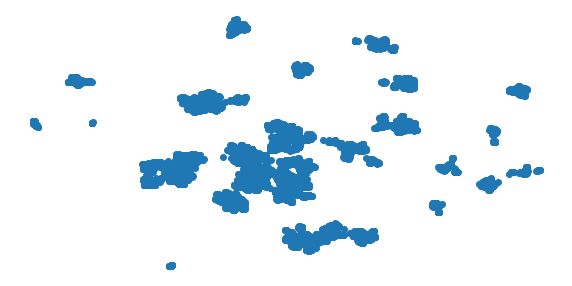

In [61]:
plt.figure(figsize=(10,5))
plt.scatter(umap_results[:, 0], umap_results[:, 1])
plt.xticks([])
plt.yticks([])
plt.axis('off')
plt.show()

#### Analysis:
Looks to have seperated out into distinguishiable clusters. 20 outperform 2 in appearance. Best of dimension reduction techniques based on visual inspection.  

#### Performance  
>Best performing Clustering Algorithm: GMM - Spherical.  
>Best performing Dimension Reduction algorithm: UMAP.   

#### Dimensionality reduction vs clustering algorithms and how they enable you to gain insights regarding the data.

* Both process unlabeled data in order to derive patterns, hopefully significant patterns.

* Dimensionality reduction: Dimensionality reduction reduces the number of features used in analysis while attempting to minimize the loss of information. 

* Clustering algorithms: Clustering assigns an observation to a group based on similarity.  